# Ridge regression
**Important**: Change the kernel to *PROJECT_NAME local*. You can do this from the *Kernel* menu under *Change kernel*.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import pickle
import os
import scipy.stats as st

In [2]:
model_name = "ridge"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(os.path.join(aml_dir, 'nyc_demand_train.csv'), parse_dates=['timeStamp'])

Create model pipeline:
- **one-hot encode categorical variables**
- **randomized parameter search** with cross validation to find optimal values for the alpha parameter

Fitting this pipeline should take less than a minute.

In [3]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [4]:
cat_cols = ['hour', 'month', 'dayofweek']
cat_cols_idx = [X.columns.get_loc(c) for c in X.columns if c in cat_cols]
onehot = OneHotEncoder(categorical_features=cat_cols_idx, sparse=False)
regr = Ridge(fit_intercept=False)
tscv = TimeSeriesSplit(n_splits=3)

In [5]:
param_dist = {'alpha': st.uniform(1e-4, 10.0)}
regr_cv = RandomizedSearchCV(estimator=regr,
                            param_distributions=param_dist,
                            n_iter=100,
                            scoring='neg_mean_squared_error',
                            iid=False,
                            cv=tscv,
                            verbose=2,
                            n_jobs=-1)
regr_pipe = Pipeline([('onehot', onehot), ('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   16.2s finished


Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=[2, 3, 4], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=Ridge(...it=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2))])

In [6]:
with open(os.path.join(aml_dir, model_name + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)

Cross validation results

In [7]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
7,0.062499,0.000000,-3869.631955,-4220.063533,6.3633,{'alpha': 6.36329711533},1,-4166.834212,-4383.040888,-3678.443996,-4236.905057,-3763.617657,-4040.244653,0.012757,0.000000,213.010992,140.451753
45,0.075710,0.006542,-3869.634107,-4220.294152,6.52927,{'alpha': 6.52926570367},2,-4167.099882,-4383.519133,-3678.346225,-4237.048816,-3763.456213,-4040.314508,0.008769,0.006628,213.190593,140.612690
22,0.070392,0.001333,-3869.634377,-4220.307744,6.53897,{'alpha': 6.53897252438},3,-4167.115685,-4383.547296,-3678.340604,-4237.057301,-3763.446842,-4040.318634,0.023106,0.001885,213.201180,140.622163
36,0.068261,0.000000,-3869.635068,-4220.339395,6.56155,{'alpha': 6.56154564971},4,-4167.152548,-4383.612870,-3678.327574,-4237.077065,-3763.425081,-4040.328249,0.020225,0.000000,213.225834,140.644220
33,0.062497,0.000000,-3869.635342,-4219.802714,6.17258,{'alpha': 6.17258190792},5,-4166.539706,-4382.499137,-3678.560270,-4236.742963,-3763.806051,-4040.166042,0.012756,0.000000,212.807991,140.269303


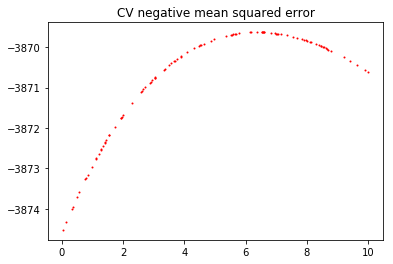

In [8]:
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], 'ro', markersize=1)
plt.title('CV negative mean squared error')
plt.show()